## Notebook realizando la actividad que está en github

La actividad es hacer regresión logistica con este mismo dataset, pero esta vez utilizando todas las columnas posibles



Dataset sacado de: https://github.com/microsoft/ML-For-Beginners/blob/main/2-Regression/data/US-pumpkins.csv

In [349]:
import pandas as pd
import numpy as np
import sklearn


full_pumpkins = pd.read_csv('../data/US-pumpkins.csv')

full_pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [350]:
#Contando valores nulos en cada columna

print(full_pumpkins.shape)
full_pumpkins.isnull().sum()

(1757, 26)


City Name             0
Type               1712
Package               0
Variety               5
Sub Variety        1461
Grade              1757
Date                  0
Low Price             0
High Price            0
Mostly Low          103
Mostly High         103
Origin                3
Origin District    1626
Item Size           279
Color               616
Environment        1757
Unit of Sale       1595
Quality            1757
Condition          1757
Appearance         1757
Storage            1757
Crop               1757
Repack                0
Trans Mode         1757
Unnamed: 24        1757
Unnamed: 25        1654
dtype: int64

In [351]:
#Eliminando las columnas con menos de 1000 valores no-nulos y eliminando los registros nulos en las columnas restantes

clean_pumpkins = full_pumpkins.dropna(axis=1, thresh=1000)
clean_pumpkins = clean_pumpkins.dropna()
clean_pumpkins.head()

,City Name,Package,Variety,Date,Low Price,High Price,Mostly Low,Mostly High,Origin,Item Size,Color,Repack
2,BALTIMORE,24 inch bins,HOWDEN TYPE,9/24/16,160.0,160.0,160.0,160.0,DELAWARE,med,ORANGE,N
3,BALTIMORE,24 inch bins,HOWDEN TYPE,9/24/16,160.0,160.0,160.0,160.0,VIRGINIA,med,ORANGE,N
4,BALTIMORE,24 inch bins,HOWDEN TYPE,11/5/16,90.0,100.0,90.0,100.0,MARYLAND,lge,ORANGE,N
5,BALTIMORE,24 inch bins,HOWDEN TYPE,11/12/16,90.0,100.0,90.0,100.0,MARYLAND,lge,ORANGE,N
6,BALTIMORE,36 inch bins,HOWDEN TYPE,9/24/16,160.0,170.0,160.0,170.0,MARYLAND,med,ORANGE,N


In [352]:
#Viendo distribucion de los colores
print(clean_pumpkins['Color'].value_counts())

#Quitando 643 registros con calabazas naranjas, para balancear el dataset
drop_indexes = clean_pumpkins[clean_pumpkins['Color'] == 'ORANGE'].sample(644).index
clean_pumpkins.drop(drop_indexes, inplace=True)

print(clean_pumpkins['Color'].value_counts())


Color
ORANGE    795
WHITE     151
Name: count, dtype: int64
Color
ORANGE    151
WHITE     151
Name: count, dtype: int64


In [353]:
#Creando una nueva columna con el mes en el que se cosecho cada calabaza y quitando las fechas

month = pd.DatetimeIndex(clean_pumpkins['Date']).month
clean_pumpkins['Month'] = month
clean_pumpkins.drop(axis=1, columns='Date', inplace=True)

#Creando una columna con el precio promedio y quitando las columnas con precios altos y bajos

price = (clean_pumpkins['High Price'] + clean_pumpkins['Low Price']) / 2
clean_pumpkins['Price'] = price
clean_pumpkins.drop(axis=1, columns=['High Price', 'Low Price', "Mostly Low", "Mostly High"], inplace=True)

In [354]:
#Viendo los valores unicos de las columnas no-numericas 

for column in clean_pumpkins.columns.difference(['Price', 'Month']):
    print(clean_pumpkins[column].value_counts())


City Name
BOSTON           81
CHICAGO          48
COLUMBIA         48
BALTIMORE        45
DALLAS           24
NEW YORK         16
LOS ANGELES      12
SAN FRANCISCO     9
ATLANTA           7
DETROIT           6
PHILADELPHIA      5
MIAMI             1
Name: count, dtype: int64
Color
ORANGE    151
WHITE     151
Name: count, dtype: int64
Item Size
sml        110
lge         48
jbo         45
med         38
xlge        34
med-lge     24
exjbo        3
Name: count, dtype: int64
Origin
MASSACHUSETTS     54
PENNSYLVANIA      53
MICHIGAN          40
MARYLAND          29
OHIO              29
TEXAS             22
CALIFORNIA        21
ILLINOIS          16
VIRGINIA          15
CANADA            10
NORTH CAROLINA     5
NEW YORK           2
MEXICO             2
VERMONT            1
ALABAMA            1
NEW JERSEY         1
DELAWARE           1
Name: count, dtype: int64
Package
36 inch bins            109
24 inch bins             99
1/2 bushel cartons       77
bushel cartons           11
1 1/9 bushel 

In [355]:
#Quitando la columna Repack ya que todos los registros tienen el mismo valor

clean_pumpkins.drop(axis=1, columns='Repack', inplace=True)


In [356]:
#Se quita la unica fila con el tipo "bins" ya que faltan detalles y ademas es una categoria con un solo dato
clean_pumpkins = clean_pumpkins[clean_pumpkins['Package'] != 'bins']

#Las bushel crates y los bushel cartons tienen el mismo volumen. La diferencia solo esta en la forma y el material de la caja. Por lo que
#se las convierte en una sola categoria
clean_pumpkins.loc[clean_pumpkins['Package'] == '1 1/9 bushel crates', 'Package'] = '1 1/9 bushel cartons'

#Estandarizando precios para que queden en bushel cartons, segun estimaciones de ChatGPT
clean_pumpkins.loc[clean_pumpkins['Package'] == '36 inch bins', 'Price'] = clean_pumpkins['Price'] / 7.23
clean_pumpkins.loc[clean_pumpkins['Package'] == '24 inch bins', 'Price'] = clean_pumpkins['Price'] / 2.41
clean_pumpkins.loc[clean_pumpkins['Package'] == '1 1/9 bushel cartons', 'Price'] = clean_pumpkins['Price'] / (10/9)
clean_pumpkins.loc[clean_pumpkins['Package'] == '1/2 bushel cartons', 'Price'] = clean_pumpkins['Price'] / 0.5

clean_pumpkins.head()

,City Name,Package,Variety,Origin,Item Size,Color,Month,Price
3,BALTIMORE,24 inch bins,HOWDEN TYPE,VIRGINIA,med,ORANGE,9,66.390041
6,BALTIMORE,36 inch bins,HOWDEN TYPE,MARYLAND,med,ORANGE,9,22.821577
10,BALTIMORE,36 inch bins,HOWDEN TYPE,MARYLAND,med,ORANGE,10,22.821577
15,BALTIMORE,36 inch bins,HOWDEN TYPE,MARYLAND,med,ORANGE,10,20.746888
21,BALTIMORE,36 inch bins,HOWDEN TYPE,MARYLAND,med,ORANGE,11,13.139696


In [357]:
#Codificando la columnas ordinales Package y Item Size
from sklearn.preprocessing import OrdinalEncoder
item_size_categories = ['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']
item_package_categories = ["36 inch bins", "24 inch bins", "1 1/9 bushel cartons", "bushel cartons", "1/2 bushel cartons"]

ordinal_features = ['Package', 'Item Size']

ordinal_encoder = OrdinalEncoder(categories=[item_package_categories, item_size_categories])

In [358]:
#Codificando el resto de columnas categoricas con un OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_features = clean_pumpkins.drop(axis=1, columns=ordinal_features + ['Price', 'Month', "Color"]).columns # type: ignore

onehot_encoder = OneHotEncoder(sparse_output=False)

In [359]:
#Utilizando ColumnTransformer para combinar varios codificadores en un solo paso y aplicarlos a las columnas correspondientes
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    transformers=[
        ('oneh', onehot_encoder, onehot_features),
        ('ord', ordinal_encoder, ordinal_features)
    ]
)

ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(clean_pumpkins)
encoded_features.head()

,oneh__City Name_ATLANTA,oneh__City Name_BALTIMORE,oneh__City Name_BOSTON,oneh__City Name_CHICAGO,oneh__City Name_COLUMBIA,oneh__City Name_DALLAS,oneh__City Name_DETROIT,oneh__City Name_LOS ANGELES,oneh__City Name_MIAMI,oneh__City Name_NEW YORK,...,oneh__Origin_NEW JERSEY,oneh__Origin_NEW YORK,oneh__Origin_NORTH CAROLINA,oneh__Origin_OHIO,oneh__Origin_PENNSYLVANIA,oneh__Origin_TEXAS,oneh__Origin_VERMONT,oneh__Origin_VIRGINIA,ord__Package,ord__Item Size
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [360]:
#Utilizando LabelEncoder para normalizar las etiquetas, de tal forma que estas solo contengan valores entre 0 y n_labels-1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(clean_pumpkins['Color'])

#Uniendo etiquetas y caracteristicas en un solo DF
encoded_df = encoded_features.assign(Color=encoded_label)

In [361]:
#Seleccionando variables y dividiendo datos
from sklearn.model_selection import train_test_split

X = encoded_df.drop(axis=1, columns='Color')
y = encoded_df['Color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Creando y entrenando modelo
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#Imprimiendo metricas y predicciónes
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        31
           1       0.94      0.97      0.95        30

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61

Predicted labels:  [0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0
 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0]
F1-score:  0.9508196721311475


<Axes: >

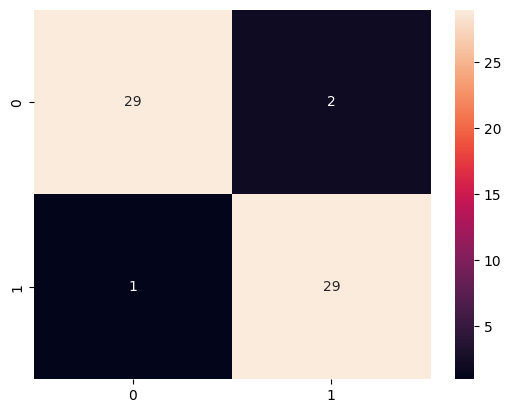

In [362]:
#Calculando matriz de confusion y graficandola con un heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d")

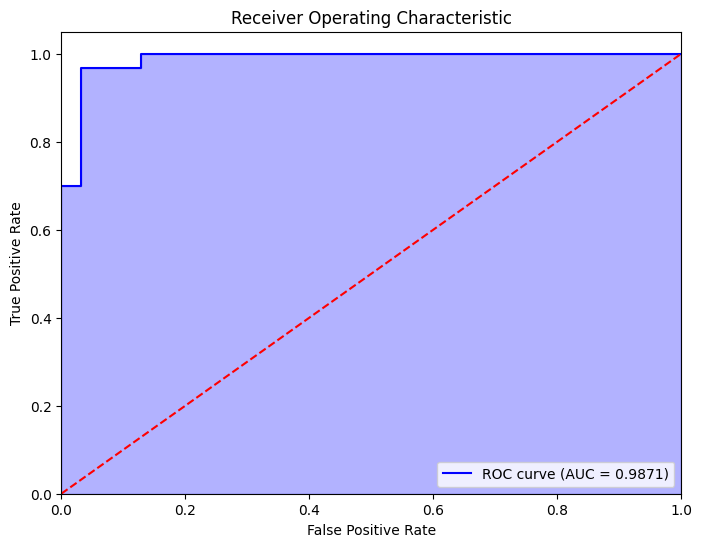

In [363]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Resaltar el AUC
plt.fill_between(fpr, tpr, alpha=0.3, color='blue')

# Mostrar el gráfico
plt.show()
